In [1]:
import fastavro as fa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from csr import CSRModel

In [2]:
with open('csr.avro', 'rb') as f:
    df = pd.DataFrame.from_records([record for record in fa.reader(f)])
df.loc[df['gender'] == 0, 'gender'] = 'Male'
df.loc[df['gender'] == 1, 'gender'] = 'Female'
df.loc[df['gender'] == 2, 'gender'] = 'Other'

In [3]:
# save path
path = 'website/app/static/img/dataset-analysis'

In [4]:
def plot_field_distribution(df, field, bins, range_=None):
    plt.hist(df[field], bins=bins, range=range_)
    plt.gca().set(title=f"{field.replace('_', ' ').title()} Distribution", ylabel='Frequency', xlabel=field.replace('_', ' ').title())
    plt.savefig(f'{path}/{field}-distribution.png', bbox_inches='tight')

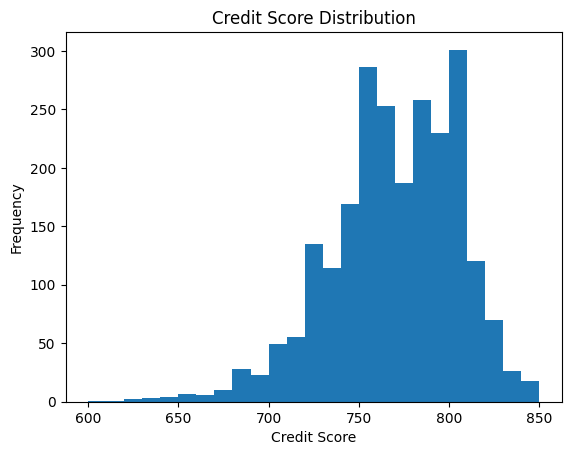

In [5]:
plot_field_distribution(df, 'credit_score', 25, (600, 850))

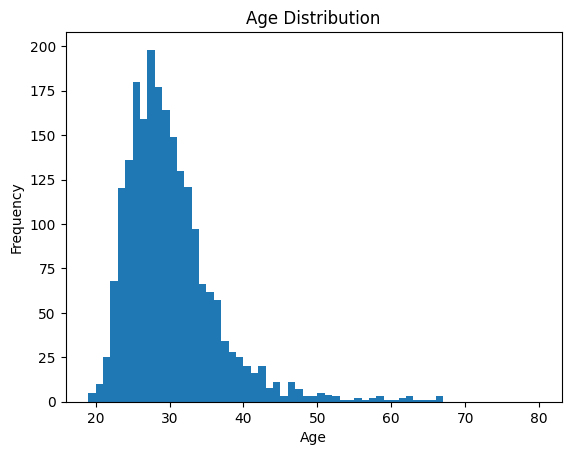

In [6]:
plot_field_distribution(df, 'age', 80 - 19, (19, 80))

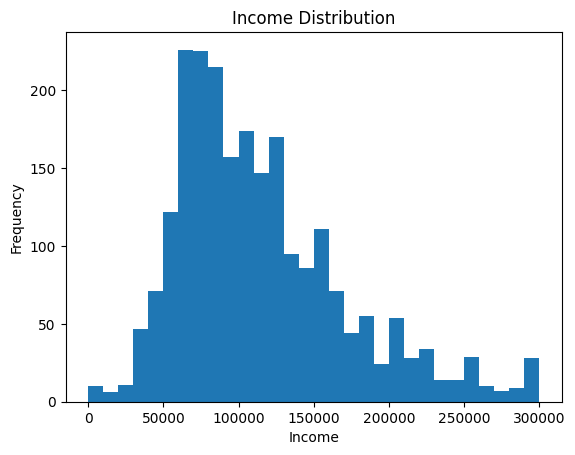

In [7]:
plot_field_distribution(df, 'income', 30, (0, 300_000))

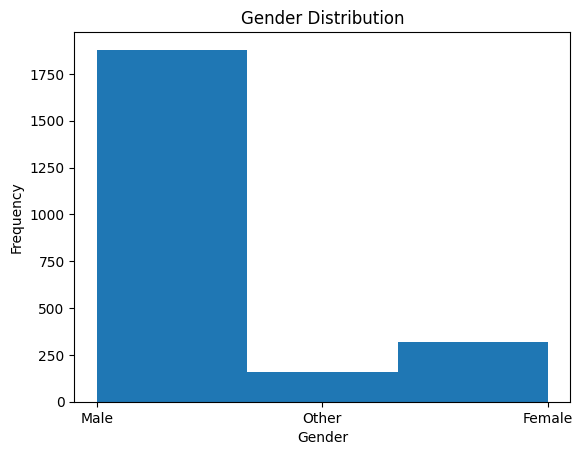

In [8]:
plot_field_distribution(df, 'gender', 3)

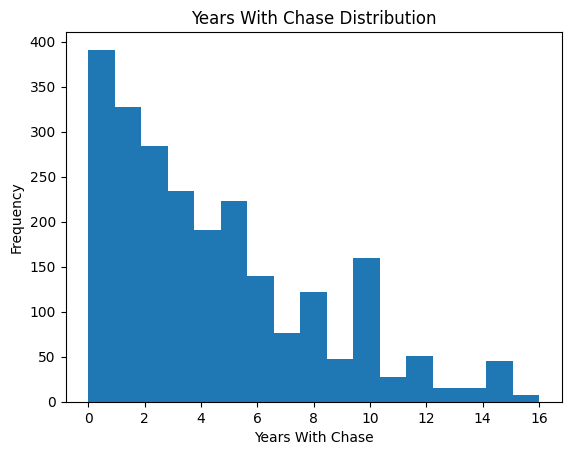

In [9]:
plot_field_distribution(df, 'years_with_chase', len(set(df['years_with_chase'])))

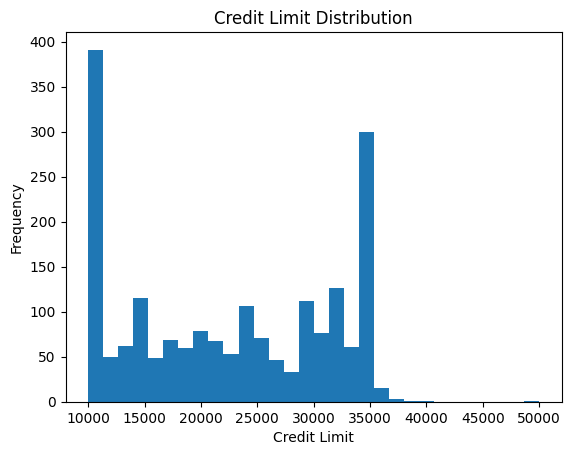

In [10]:
plot_field_distribution(df, 'credit_limit', 30, (10_000, 50_000))

In [11]:
def nan_to_zero(x):
    if isinstance(x:=x.mean(), np.float64):
        return x
    return 0

def plot_percent_approved(df, field, bins, range_=None, gender=False):
    _, bin_edges = np.histogram(df[field], bins, range_)
    # get rid of 5/24 > 5
    is_5_24 = df['relative_5/24'] != 1
    approval_rates = []
    plt_hist = []
    
    for bin_num in range(len(bin_edges) - 1):
        right_edge = df[field] < bin_edges[bin_num + 1] if bin_num != len(bin_edges) - 2 else df[field] <= bin_edges[bin_num + 1]
        
        # plt bar charts look weird, so make it a histogram by adding the percent x 100 times to a list
        for i in range((int(100 * nan_to_zero(df[(bin_edges[bin_num] <= df[field]) & right_edge & is_5_24]['instant_approval'] == 2)))):
            
            plt_hist.append(['Male', 'Female', 'Other'][int(bin_edges[bin_num])] if gender else bin_edges[bin_num])
            
    plt.hist(plt_hist, bins=bins, range=range_ if not gender else None)
    plt.gca().set(title=f"{field.replace('_', ' ').title()} Applications Approved (5/24 < 5)", ylabel='%', xlabel=field.replace('_', ' ').title())
    plt.savefig(f'{path}/{field}-approved.png', bbox_inches='tight')

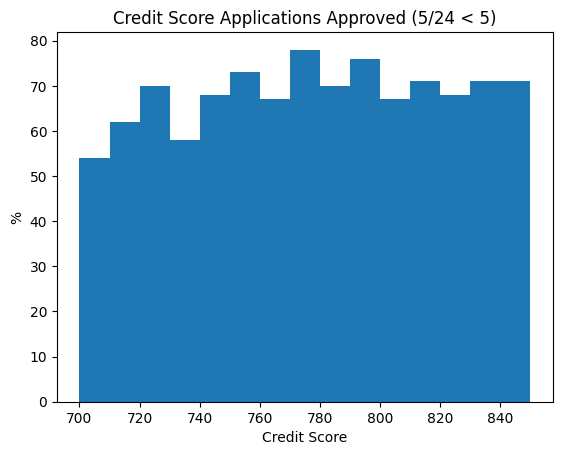

In [12]:
plot_percent_approved(df, 'credit_score', 15, range_=(700, 850))

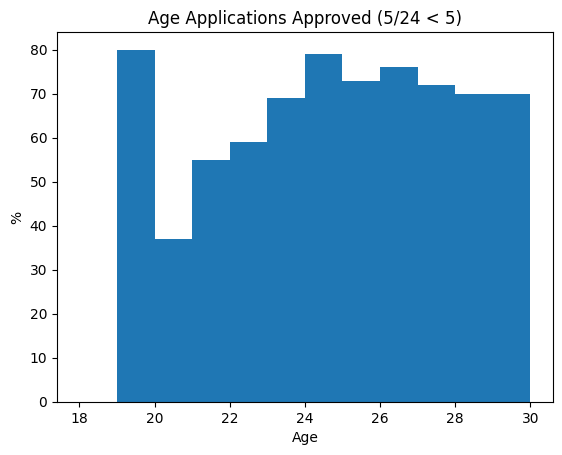

In [13]:
plot_percent_approved(df, 'age', 30 - 18, (18, 30))

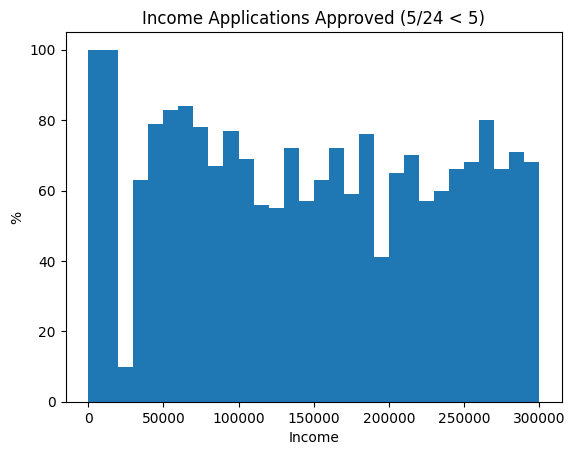

In [14]:
plot_percent_approved(df, 'income', 30, range_=(0, 300_000))

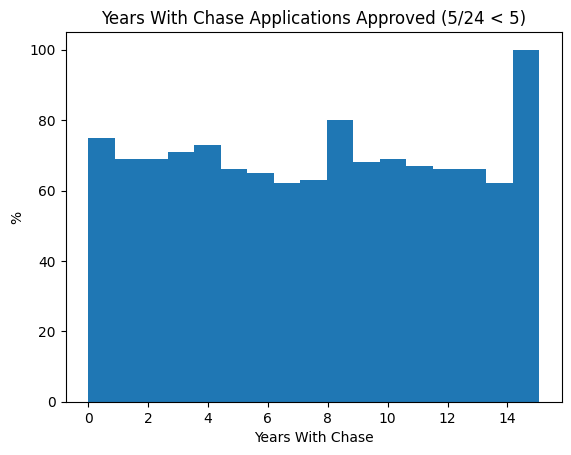

In [15]:
plot_percent_approved(df, 'years_with_chase', 17)

In [16]:
df.loc[df['gender'] == 'Male', 'gender'] = 0
df.loc[df['gender'] == 'Female', 'gender'] = 1
df.loc[df['gender'] == 'Other', 'gender'] = 2
df['gender'] = df['gender'].astype('int64')

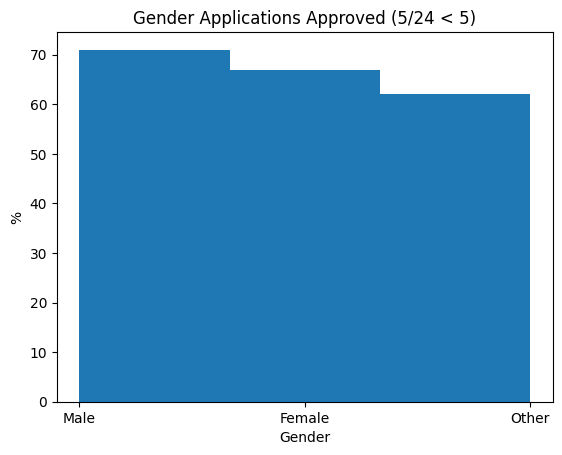

In [17]:
plot_percent_approved(df, 'gender', 3, (0, 3), True)

In [18]:
n_df = df.drop(['instant_approval', 'credit_limit'], axis=1)

In [19]:
model = CSRModel(None, 5, ensemble=True)

model.load('website/model')

In [20]:
def plot_probas(model, df, field, range_, step=1, gender=False):
    modified_apps = df.copy()
    # x axis
    field_values = np.arange(range_[0], range_[1] + 1, step)
    probas = []
    for field_value in field_values:
        modified_apps[field] = field_value
        # calculate the model probabilities on the entire dataset with one field modified and average the instant approval percent
        probas.append(100 * model.predict_proba(modified_apps)[:, 2].mean())
    if gender:
        plt.plot(['Male', 'Female', 'Other'], probas)
    else:
        plt.plot(field_values, probas)
    plt.gca().set(title=f"{field.replace('_', ' ').title()} Model Odds", ylabel='%', xlabel=field.replace('_', ' ').title())
    plt.savefig(f'{path}/{field}-model.png', bbox_inches='tight')

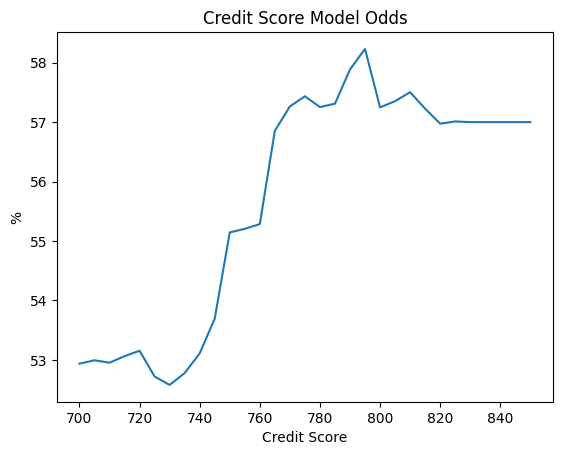

In [21]:
plot_probas(model, n_df, 'credit_score', (700, 850), step=5)

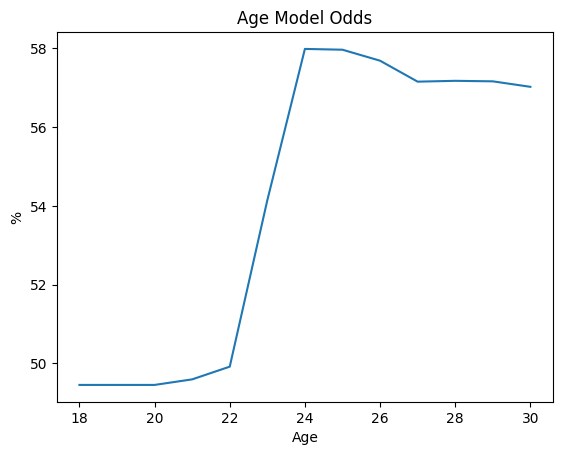

In [22]:
plot_probas(model, n_df, 'age', (18, 30))

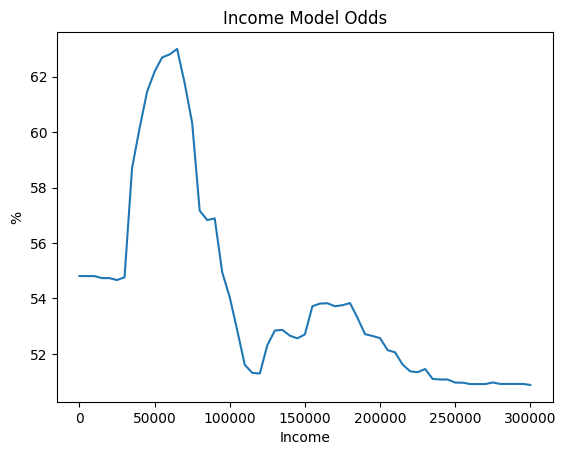

In [23]:
plot_probas(model, n_df, 'income', range_=(0, 300_000), step=5_000)

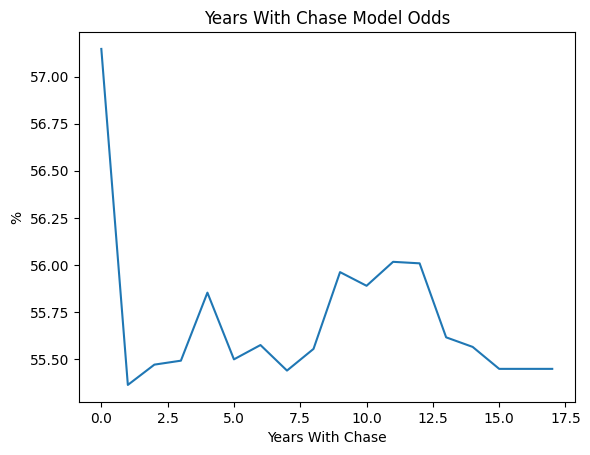

In [24]:
plot_probas(model, n_df, 'years_with_chase', range_=(0, 17))

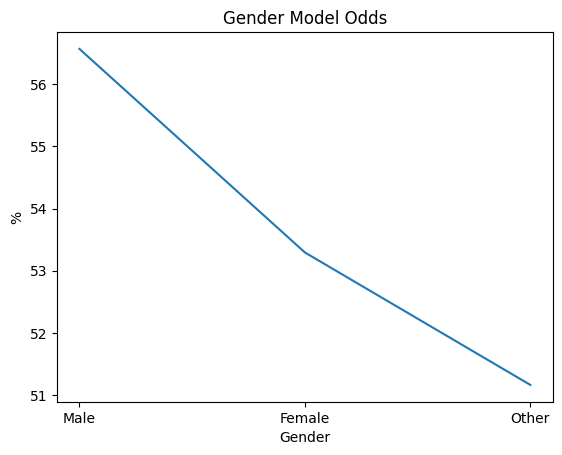

In [25]:
plot_probas(model, n_df, 'gender', range_=(0, 2), gender=True)